# Url Spam detection 

I aim to develop a machine learning system tasked with automatically discerning whether a given web page contains spam, relying solely on its URL. The dataset I'll utilize can be accessed from 'https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv'.

For this project, I plan to implement a Support Vector Machine (SVM) model and thoroughly analyze its performance and outcomes.

In [13]:
# necessary libraries
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from pickle import dump

In [3]:
#load the data

url_spam = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')
url_spam.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [4]:
#transform categorical columns to numeric

url_spam['is_spam'] = url_spam['is_spam'].astype(int)
url_spam.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


Categorical to numeric dic:
- is_spam = {
    'True': 1,
    'False': 0
}

In [5]:
print(url_spam.shape)
print(f"Spam: {len(url_spam.loc[url_spam.is_spam == 1])}")
print(f"No spam: {len(url_spam.loc[url_spam.is_spam == 0])}")

(2999, 2)
Spam: 696
No spam: 2303


In [6]:
#Delete duplicated
url_spam = url_spam.drop_duplicates()
url_spam.shape

(2369, 2)

There is a huge difference in the classes, this will cause us problem in the future, so I will assign weights to the model before training.

In [7]:
print(url_spam.shape)
print(f"Spam without duplicates: {len(url_spam.loc[url_spam.is_spam == 1])}")
print(f"No spam without duplicates: {len(url_spam.loc[url_spam.is_spam == 0])}")

(2369, 2)
Spam without duplicates: 244
No spam without duplicates: 2125


preprocess the url text

In [8]:
def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

# apply the function to the column
url_spam["url"] = url_spam["url"].apply(preprocess_text)
url_spam

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1
...,...,...
2993,"[https, www, theverge, com, disney, deepfake, ...",0
2994,"[https, www, smartcitiesworld, net, news, news...",0
2996,"[https, techcrunch, com, an, optimistic, view,...",0
2997,"[https, www, technologyreview, com, this, star...",0


In [9]:
#lemmatize and stop words
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def lematize_and_stopwords(words_list):
    lematizadas = [lemmatizer.lemmatize(word.lower(), pos='v') for word in words_list if word.lower() not in stop_words]
    return lematizadas

url_spam['url'] = url_spam['url'].apply(lematize_and_stopwords)
url_spam

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/gitpod/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/gitpod/nltk_data...


,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v]",1
3,"[https, briefingday, com, commentform]",0
4,"[https, briefingday, com, fan]",1
...,...,...
2993,"[https, www, theverge, com, disney, deepfake, ...",0
2994,"[https, www, smartcitiesworld, net, news, news...",0
2996,"[https, techcrunch, com, optimistic, view, dee...",0
2997,"[https, www, technologyreview, com, startup, c...",0


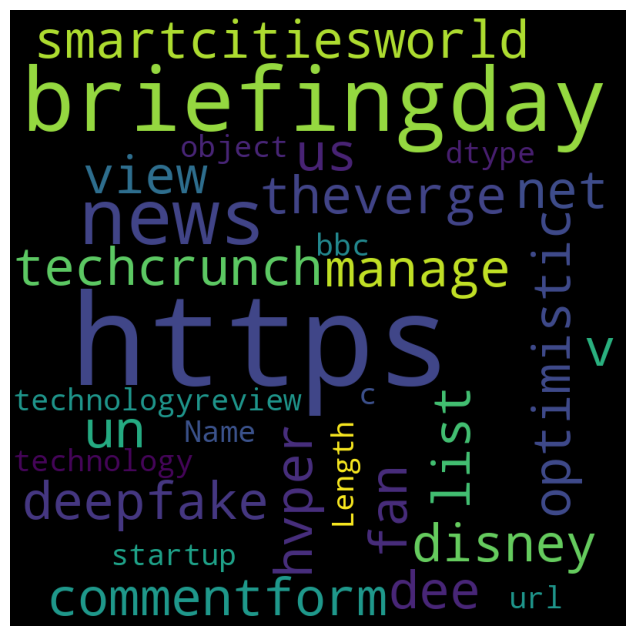

In [10]:
#plot the word cloud
wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 28)\
    .generate(str(url_spam["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [11]:
#vectorize the url column

tokens_ = url_spam["url"]
tokens_ = [" ".join(tokens) for tokens in tokens_]

# set the vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(tokens_).toarray()
y = url_spam['is_spam']

#set the vectorizer
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(tokens_).toarray()
y = url_spam['is_spam']
print(f'X preview:\n {X}')
print(f'y preview:\n {y}')

X preview:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
y preview:
 0       1
1       1
2       1
3       0
4       1
       ..
2993    0
2994    0
2996    0
2997    0
2998    0
Name: is_spam, Length: 2369, dtype: int64


In [22]:
#split into train and test and build the model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 28)

#I try to balance the model with the class_weight='balanced' but it gave me worst accuracy

model_svm = SVC(kernel = "linear", random_state = 28)
model_svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=28)

In [23]:
#check the accuracy
y_pred = model_svm.predict(X_test)
model_accuracy = accuracy_score(y_test, y_pred)
print(f'Model accuracy: {model_accuracy}')

Model accuracy: 0.9472573839662447


In [ ]:
#save the model

dump(model_svm, open("../models/svm_classifier_linear_28.sav", "wb"))

PD: I tried the optimization but it was taken too long:(